In [1]:
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras

import modulation
import noise
from demodulation import models, data_preprocessing

In [2]:
modulator = modulation.Modulator()

In [3]:
N_SAMPLES_TRAIN = 25
N_SAMPLES_VAL = 10
SAMPLE_LEN = 50
TRAIN_SNR = -10
TRAIN_SNR_RANGE = -12, 0

def add_noise(wave):
#     snr = np.random.uniform(*TRAIN_SNR_RANGE)
#     return noise.add_white_gaussian_noise(wave, snr)
    return noise.add_white_gaussian_noise(wave, TRAIN_SNR)

train_gen = data_preprocessing.get_generator(N_SAMPLES_TRAIN, SAMPLE_LEN, modulator, add_noise)
train_ds = tf.data.Dataset.from_generator(
    train_gen, 
    ((tf.float32, tf.float32), tf.float32), 
    (((None, 1), (None, 257, 1)), (None, 16))
).batch(1)
val_data = data_preprocessing.generate_signal(N_SAMPLES_VAL, SAMPLE_LEN, modulator, add_noise)
val_ds = tf.data.Dataset.from_tensor_slices(val_data).batch(2)

In [4]:
model = models.make_common_model()

In [5]:
opt = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(.001, 20 * N_SAMPLES_TRAIN, .3))
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss_f, metrics=['acc'])
model.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100
25/25 [==============================] - 47s 2s/step - loss: 2.7120 - acc: 0.1224 - val_loss: 2.4281 - val_acc: 0.2360
Epoch 2/100
25/25 [==============================] - 41s 2s/step - loss: 1.8296 - acc: 0.4184 - val_loss: 1.4254 - val_acc: 0.5700
Epoch 3/100
25/25 [==============================] - 40s 2s/step - loss: 1.1497 - acc: 0.6288 - val_loss: 1.0935 - val_acc: 0.6440
Epoch 4/100
25/25 [==============================] - 38s 2s/step - loss: 0.9001 - acc: 0.7120 - val_loss: 0.8672 - val_acc: 0.7080
Epoch 5/100
25/25 [==============================] - 38s 2s/step - loss: 0.7091 - acc: 0.7624 - val_loss: 0.7995 - val_acc: 0.7400
Epoch 6/100
25/25 [==============================] - 40s 2s/step - loss: 0.6129 - acc: 0.7936 - val_loss: 0.7238 - val_acc: 0.7720
Epoch 7/100
25/25 [==============================] - 40s 2s/step - loss: 0.6308 - acc: 0.7976 - val_loss: 0.6683 - val_acc: 0.7800
Epoch 8/100
25/25 [==============================] - 38s 2s/step - loss: 0.6520 - a

25/25 [==============================] - 39s 2s/step - loss: 0.3675 - acc: 0.8832 - val_loss: 0.4482 - val_acc: 0.8660
Epoch 64/100
25/25 [==============================] - 38s 2s/step - loss: 0.3292 - acc: 0.8928 - val_loss: 0.4472 - val_acc: 0.8620
Epoch 65/100
25/25 [==============================] - 38s 2s/step - loss: 0.3983 - acc: 0.8792 - val_loss: 0.4457 - val_acc: 0.8600
Epoch 66/100
25/25 [==============================] - 38s 2s/step - loss: 0.3786 - acc: 0.8768 - val_loss: 0.4447 - val_acc: 0.8620
Epoch 67/100
25/25 [==============================] - 38s 2s/step - loss: 0.3902 - acc: 0.8808 - val_loss: 0.4437 - val_acc: 0.8640
Epoch 68/100
25/25 [==============================] - 39s 2s/step - loss: 0.3416 - acc: 0.8904 - val_loss: 0.4441 - val_acc: 0.8680
Epoch 69/100
25/25 [==============================] - 39s 2s/step - loss: 0.3951 - acc: 0.8616 - val_loss: 0.4434 - val_acc: 0.8680
Epoch 70/100
25/25 [==============================] - 38s 2s/step - loss: 0.3712 - acc: 0

In [6]:
test_samples = data_preprocessing.load_samples_per_snr(
    Path('test_data_-2,-4,-6,-8,-10,-12_5_50.json'))
test_samples = data_preprocessing.add_sgs_to_samples(test_samples, modulator)
test_samples = data_preprocessing.preprocess_samples_for_tf(test_samples, modulator)

test_samples_shifted = data_preprocessing.load_samples_per_snr(
    Path('test_data_-2,-4,-6,-8,-10,-12_sh20_5_50.json'))
test_samples_shifted = data_preprocessing.add_sgs_to_samples(test_samples_shifted, modulator)
test_samples_shifted = data_preprocessing.preprocess_samples_for_tf(test_samples_shifted, modulator)

In [7]:
snr_test_accuracies = []

for snr, samples in test_samples.items():
    print(f'Evaluating with SNR {snr}')
    cur_test_ds = tf.data.Dataset.from_tensor_slices(samples).batch(1)
    loss, accuracy = model.evaluate(cur_test_ds)
    snr_test_accuracies.append(accuracy)

Evaluating with SNR -2
5/5 [==============================] - 2s 309ms/step - loss: 0.0016 - acc: 1.0000
Evaluating with SNR -4
5/5 [==============================] - 2s 310ms/step - loss: 0.0022 - acc: 1.0000
Evaluating with SNR -6
5/5 [==============================] - 2s 312ms/step - loss: 0.0045 - acc: 1.0000
Evaluating with SNR -8
5/5 [==============================] - 2s 303ms/step - loss: 0.0459 - acc: 0.9960
Evaluating with SNR -10
5/5 [==============================] - 2s 313ms/step - loss: 0.4312 - acc: 0.8720
Evaluating with SNR -12
5/5 [==============================] - 2s 313ms/step - loss: 1.7214 - acc: 0.6440


In [8]:
snr_test_shifted_accuracies = []

for snr, samples in test_samples_shifted.items():
    print(f'Evaluating with SNR {snr} on shifted frequency')
    cur_test_ds = tf.data.Dataset.from_tensor_slices(samples).batch(1)
    loss, accuracy = model.evaluate(cur_test_ds)
    snr_test_shifted_accuracies.append(accuracy)

Evaluating with SNR -2 on shifted frequency
5/5 [==============================] - 2s 311ms/step - loss: 0.0061 - acc: 1.0000
Evaluating with SNR -4 on shifted frequency
5/5 [==============================] - 2s 313ms/step - loss: 0.0102 - acc: 1.0000
Evaluating with SNR -6 on shifted frequency
5/5 [==============================] - 2s 316ms/step - loss: 0.0187 - acc: 1.0000
Evaluating with SNR -8 on shifted frequency
5/5 [==============================] - 2s 305ms/step - loss: 0.1017 - acc: 0.9920
Evaluating with SNR -10 on shifted frequency
5/5 [==============================] - 2s 314ms/step - loss: 0.7560 - acc: 0.7400
Evaluating with SNR -12 on shifted frequency
5/5 [==============================] - 2s 311ms/step - loss: 3.0440 - acc: 0.4600


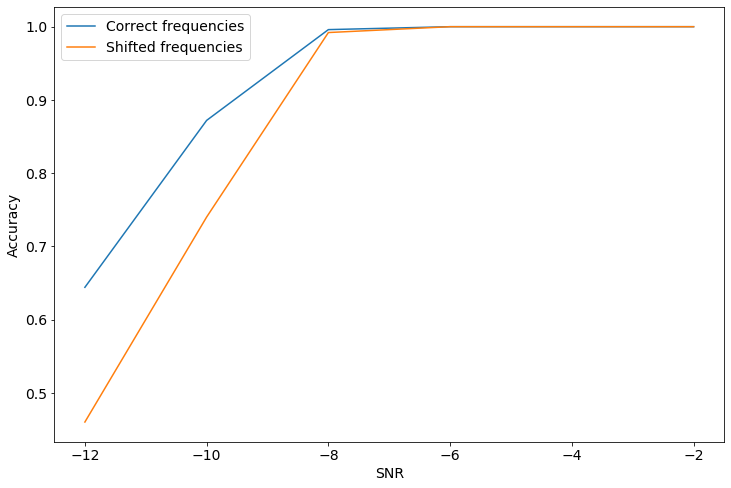

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
plt.plot(list(test_samples.keys()), snr_test_accuracies, label='Correct frequencies')
plt.plot(list(test_samples_shifted.keys()), snr_test_shifted_accuracies, label='Shifted frequencies')
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('SNR', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [10]:
model.save('params/2020_08_07_leaky_-10')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: params/2020_08_07_leaky_-10/assets
